## GAN loss

The GAN performs the following <font color=red>min-max</font> optimization
$$\max_{D}\min_{G}\Big(\log\left(D(x_{\rm real})\right) l_{\rm real} + \log\left(D(x_{\rm fake})\right) l_{\rm fake}\Big), $$

Note that the binary Cross Entropy loss between the target labels $x$ and the predicted labels $x$ are given by

$${\rm BCE}(x,l) = -\Big(l \log(x) + (1-l) \log(1-x)\Big),$$

With the above definition of BCE loss, the GAN criterion can be rewritten as the <font color=red>max-min</font> optimization problem:

$$\min_{D}\max_{G}  \Big({\rm BCE}\left(D(x_{\rm real}),\underbrace{l_{\rm real}}_{1}\right) + {\rm BCE}\left(D(\underbrace{x_{\rm fake}}_{G[z]}),\underbrace{l_{\rm fake}}_0\right)\Big)
$$

Note that the generator only maximizes the second term.
Pytorch is designed to minimize functions. For this, we could consider the minimization of the negative of the second term
$$\min_{G}  ~-{\rm BCE}\left(D(\underbrace{x_{\rm fake}}_{G[z]}),\underbrace{l_{\rm fake}}_0\right).
$$
Using the property of cross-entropy loss, one can simply swap the labels <font color=red>$l_{\rm fake} \rightarrow l_{\rm real}=1-l_{\rm fake}$</font> to rewrite the above expression as
$$\min_{G}  ~{\rm BCE}\left(D(\underbrace{x_{\rm fake}}_{G[z]}),\underbrace{y_{\rm real}}_1\right)
$$
Thus, the generator will try to get a label 1.  

### Thus, the GAN optimization alternates between the following steps.

1. Discriminator optimization $\min_{D}  \Big({\rm BCE}\left(D(x_{\rm real}),\underbrace{l_{\rm real}}_{1}\right) + {\rm BCE}\left(D(\underbrace{x_{\rm fake}}_{G[z]}),\underbrace{l_{\rm fake}}_0\right)\Big)
$

<font color=red>The discriminator optimization aims to assign $D(x_{\rm real}) \rightarrow 1$ and $D(x_{\rm fake}) \rightarrow 0$ </font>. This is a classification task and the neural network learns the discriminant.

2. Generator optimization $\min_{G}  ~{\rm BCE}\left(D(\underbrace{x_{\rm fake}}_{G[z]}),\underbrace{l_{\rm real}}_1\right)$

<font color=red>The generator tries to assign $D(x_{\rm fake}) \rightarrow 1$ </font>.




## Create data on a circle. You may change the model to see how the model will adapt to new points

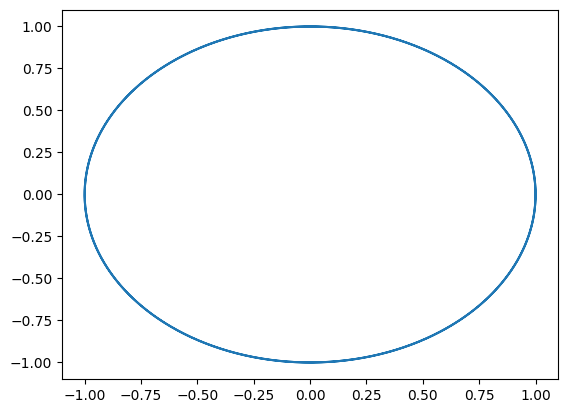

In [1]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import numpy as np
import torch
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt


# Defining the circle
N = 2000
x=np.linspace(-2*np.pi,2*np.pi,N)
y=np.sin(x)
z=np.cos(x)
Y = np.hstack((np.expand_dims(y,axis=1),np.expand_dims(z,axis=1)))

index = np.arange(N)
# Make the data look like a data set
X=np.expand_dims(x,axis=1)
index = np.expand_dims(index,axis=1)
# Use batch training
dataset=TensorDataset(torch.tensor(index,dtype=torch.long),torch.tensor(Y,dtype=torch.float))

plt.plot(y,z)


In [2]:

# The main structure of the generator, here is a simple linear structure

class generator(nn.Module):
    def __init__(self,input_dim=1, output_dim=1,base_size=20):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.base_size = base_size
        self.net=nn.Sequential(
            nn.Linear(in_features=self.input_dim,out_features=self.base_size),
            nn.ReLU(),
            nn.Linear(self.base_size,10*self.base_size),
            nn.ReLU(),
            nn.Linear(10*self.base_size,10*self.base_size),
            nn.ReLU(),
            nn.Linear(10*self.base_size,self.output_dim)
            #nn.Linear(self.base_size,self.output_dim)
        )

    def forward(self, input:torch.FloatTensor):
        return self.net(input)

# The main structure of the discriminator, here is a simple linear structure

class discriminator(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, base_size=10):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.base_size = 64

        self.fc = nn.Sequential(
            nn.Linear(input_dim, self.base_size),
            nn.LeakyReLU(0.2),
            nn.Linear(self.base_size, 2*self.base_size),
            nn.LeakyReLU(0.2),
            nn.Linear(2*self.base_size, self.output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.fc(x)
        return x

## Function to display the discriminant along with fake and real points

In [3]:
def plotDiscriminant_And_Points(D,truePts,fakePts,Ngrid=20,ext=1.2,title=""):
# Construct testing meshgrid

  Ngrid = 20
  xtest = np.linspace(-ext, ext, Ngrid)
  ytest = np.linspace(-ext, ext, Ngrid)
  xtest, ytest = np.meshgrid(xtest, ytest)
  Xtest = np.hstack((xtest.ravel().reshape(-1,1),ytest.ravel().reshape(-1,1)))
  Xtest = torch.tensor(Xtest).type(torch.FloatTensor).cuda()
  yTest = D(Xtest)
  yTest = np.reshape(yTest.detach().cpu().numpy(),(Ngrid,Ngrid))
  fig = plt.figure()
  s = plt.imshow(yTest, extent=[-ext,ext,-ext,ext], origin='lower')
  s = plt.colorbar()

  plt.scatter(truePts[:,0].cpu().numpy(),truePts[:,1].cpu().numpy(),c='m')
  plt.scatter(fakePts[:,0].detach().cpu().numpy(),fakePts[:,1].detach().cpu().numpy(),c='r')
  plt.title(title)
  plt.show()


## Train discriminator separately.

We optimize the discriminator such that the cross-entropy loss between the data and the labels are minimized. This classification task would learn a discriminant, which classifies the two datasets

$$\min_{D}  \Big({\rm BCE}\left(D(x_{\rm real}),\underbrace{y_{\rm real}}_{1}\right) + {\rm BCE}\left(D(\underbrace{x_{\rm fake}}_{G[z]}),\underbrace{y_{\rm fake}}_0\right)\Big)
$$

Dloss = 1.3793038 ;Gloss= 0.6443857


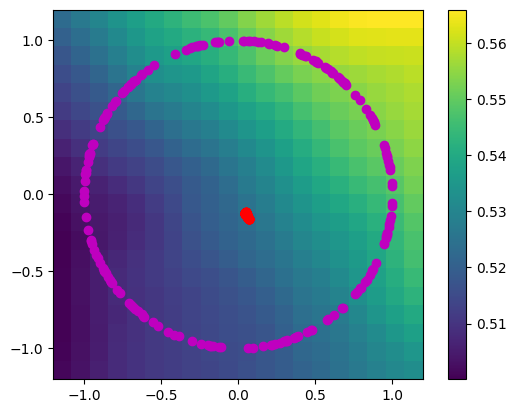

Dloss = 1.062514 ;Gloss= 0.89242905


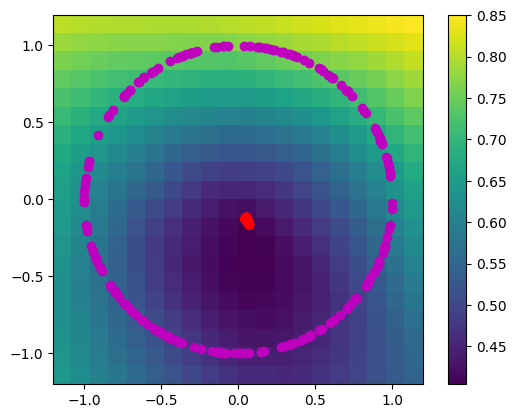

Dloss = 0.50317705 ;Gloss= 1.4877664


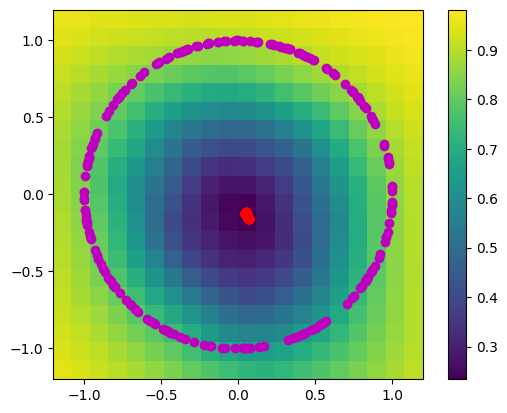

Dloss = 0.17234188 ;Gloss= 2.4901059


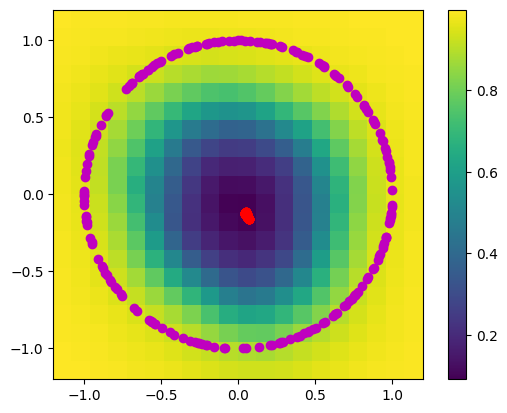

Dloss = 0.07039428 ;Gloss= 3.4050183


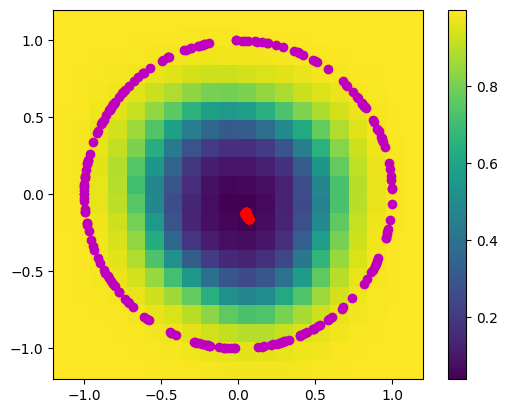

Dloss = 0.032536298 ;Gloss= 4.122316


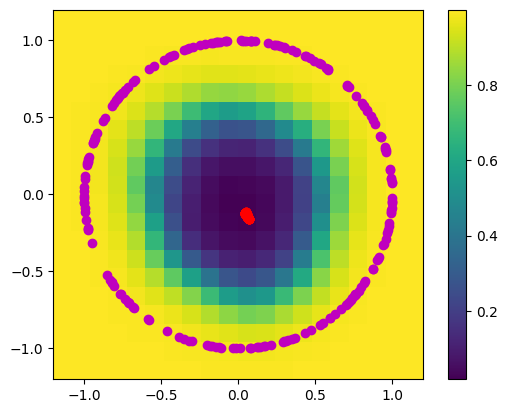

Dloss = 0.017825145 ;Gloss= 4.720086


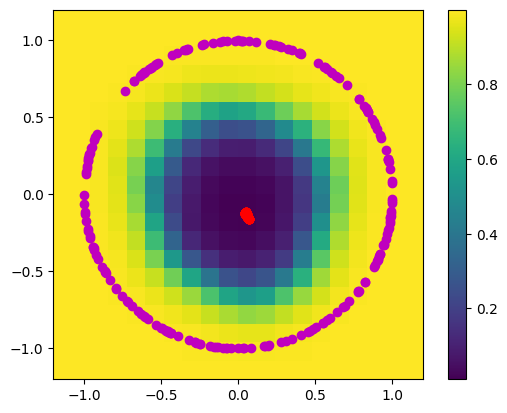

Dloss = 0.011120126 ;Gloss= 5.194871


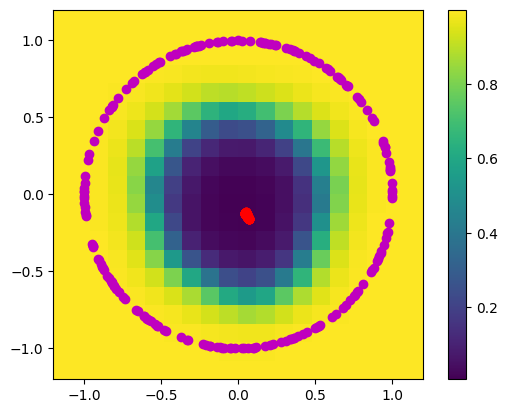

Dloss = 0.007551796 ;Gloss= 5.5996943


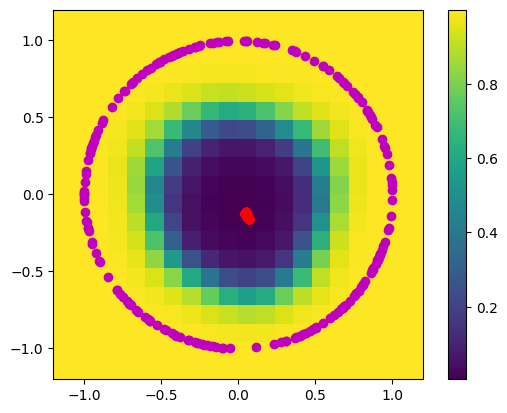

Dloss = 0.0052134935 ;Gloss= 5.9334702


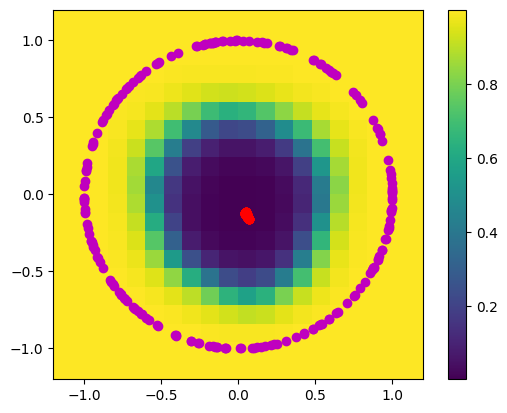

Dloss = 0.003927858 ;Gloss= 6.2717032


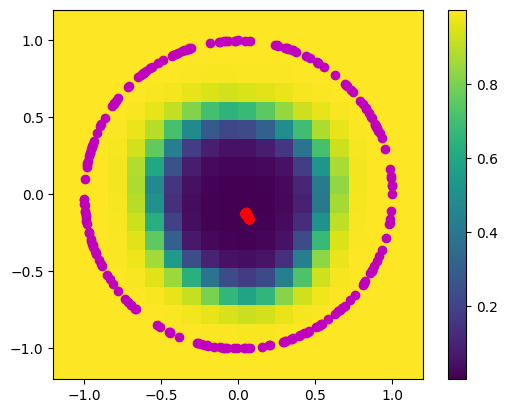

Dloss = 0.002833242 ;Gloss= 6.5666537


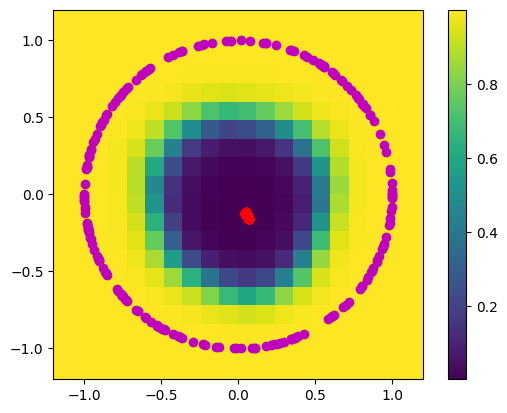

Dloss = 0.0021824276 ;Gloss= 6.8405905


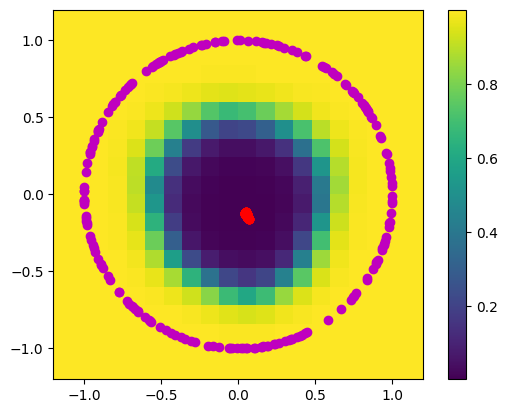

Dloss = 0.0017110932 ;Gloss= 7.087446


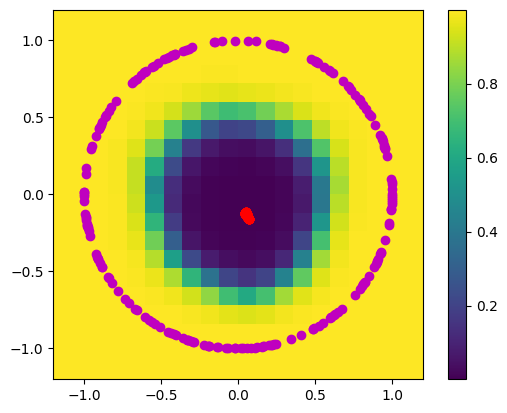

Dloss = 0.0013224815 ;Gloss= 7.334961


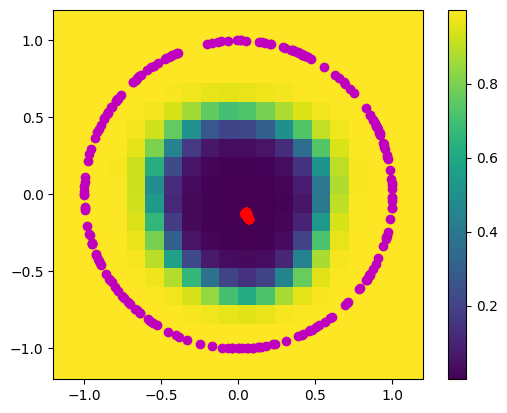

Dloss = 0.0010175249 ;Gloss= 7.5822067


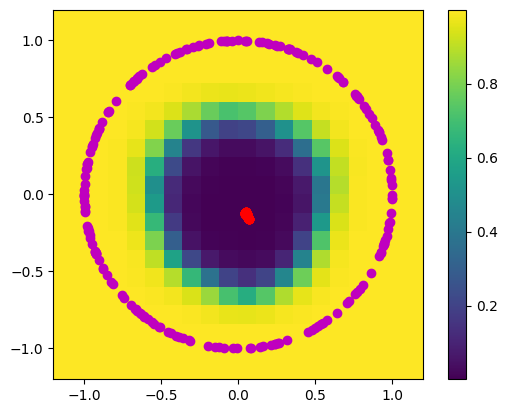

Dloss = 0.00083227234 ;Gloss= 7.8403225


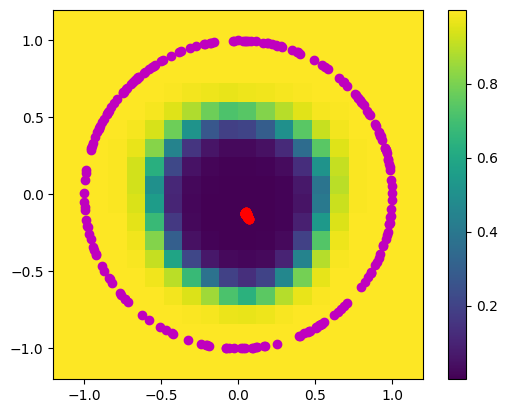

Dloss = 0.0006631323 ;Gloss= 8.0441675


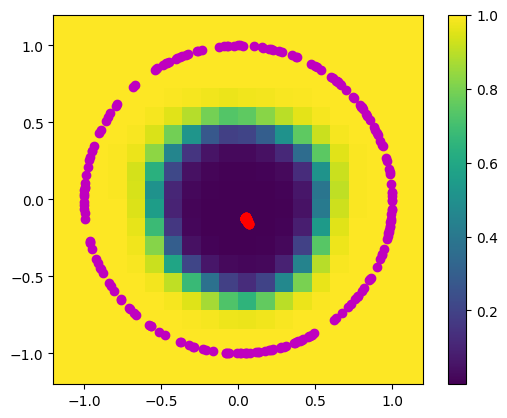

Dloss = 0.0005426471 ;Gloss= 8.229697


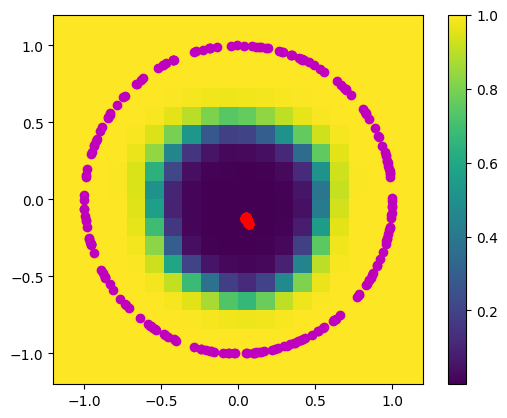

Dloss = 0.00045089336 ;Gloss= 8.418622


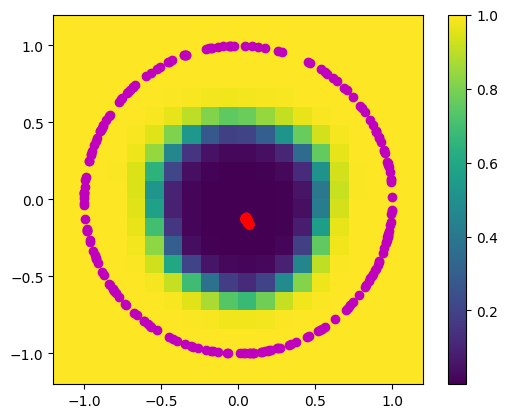

Dloss = 0.0003714215 ;Gloss= 8.61635


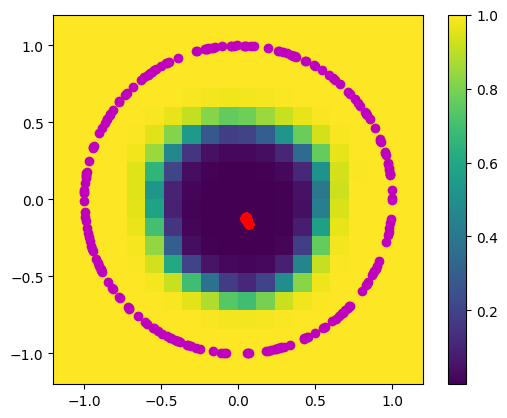

Dloss = 0.00030815857 ;Gloss= 8.811371


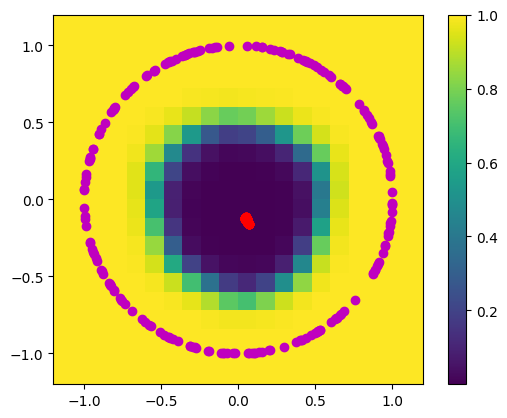

Dloss = 0.00025498756 ;Gloss= 8.984839


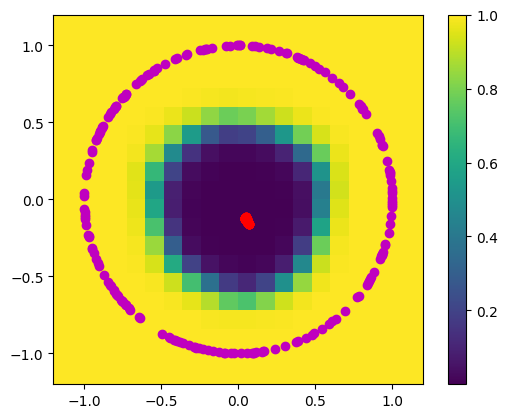

Dloss = 0.00021159538 ;Gloss= 9.168044


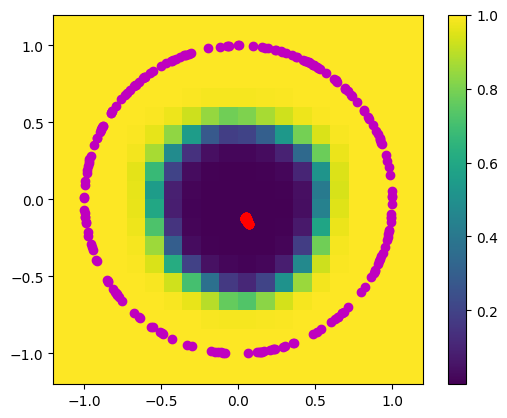

Dloss = 0.00017666935 ;Gloss= 9.315512


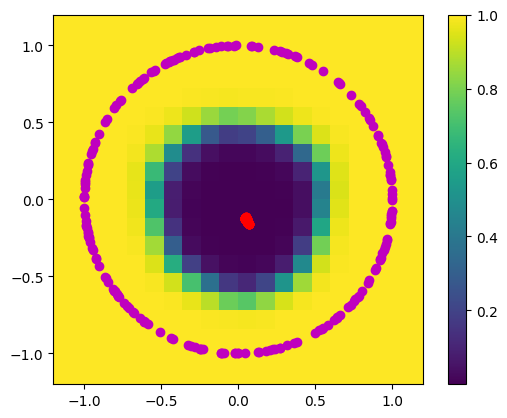

Dloss = 0.00015270353 ;Gloss= 9.498249


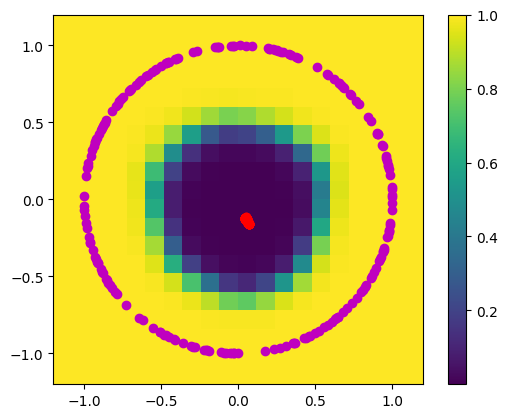

Dloss = 0.00012246979 ;Gloss= 9.667806


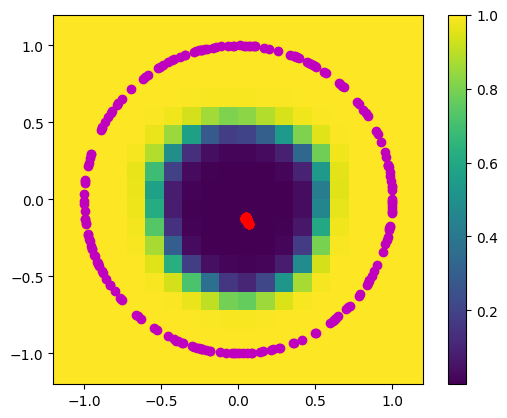

Dloss = 0.00011110115 ;Gloss= 9.827386


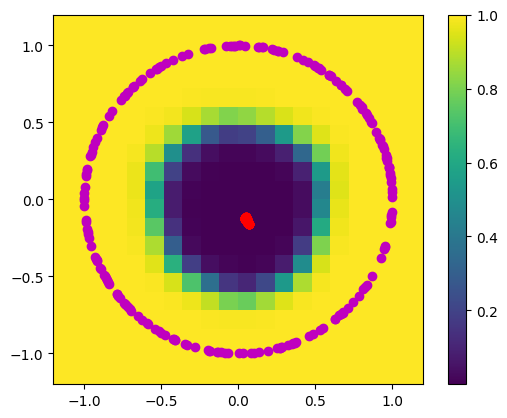

Dloss = 9.108322e-05 ;Gloss= 9.980022


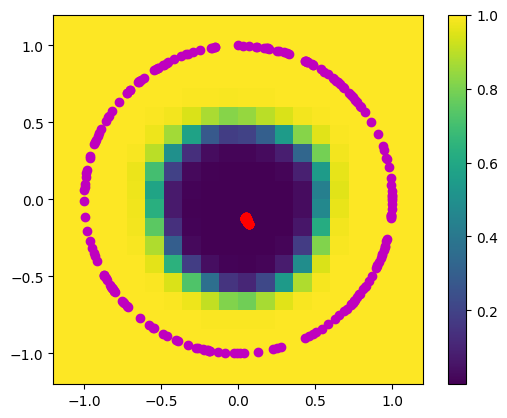

Dloss = 8.040409e-05 ;Gloss= 10.151875


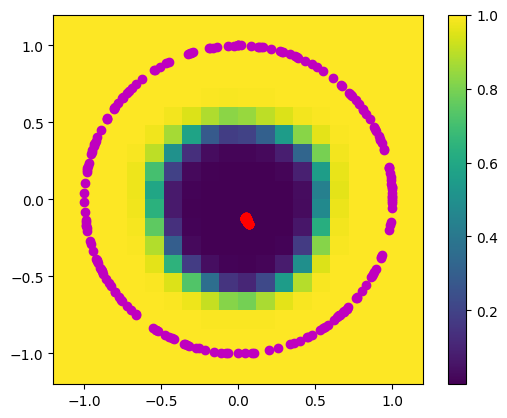

Dloss = 6.627022e-05 ;Gloss= 10.3409815


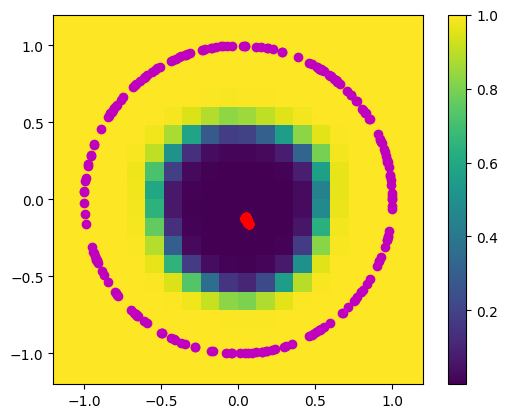

Dloss = 5.6025463e-05 ;Gloss= 10.490127


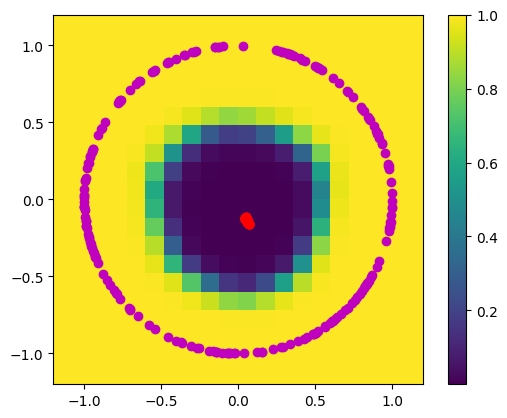

Dloss = 4.8119953e-05 ;Gloss= 10.65509


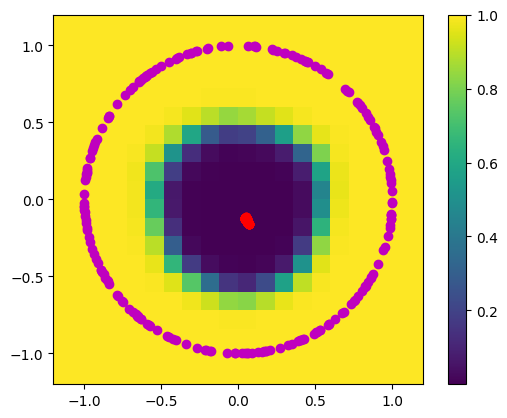

Dloss = 4.2058957e-05 ;Gloss= 10.787964


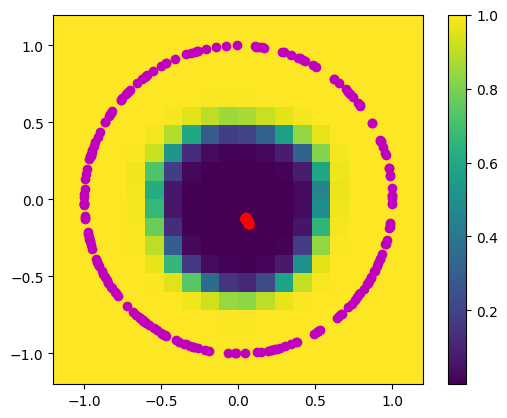

Dloss = 3.4600285e-05 ;Gloss= 10.962551


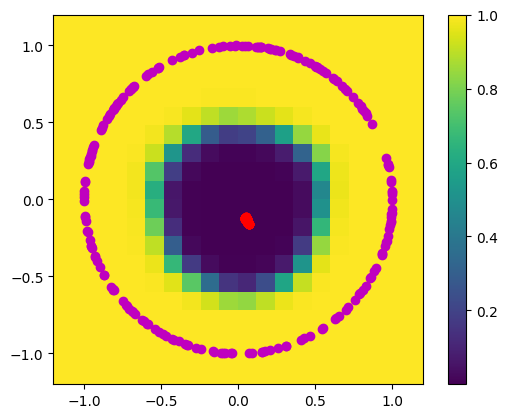

Dloss = 2.9981165e-05 ;Gloss= 11.103711


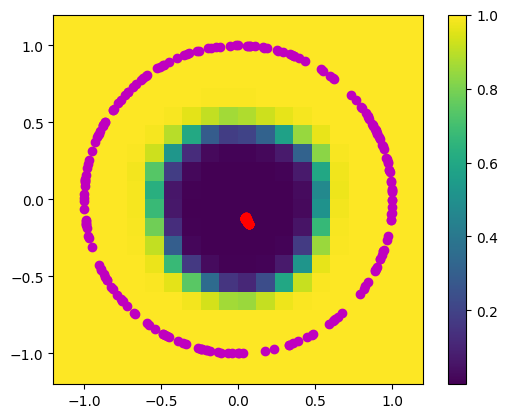

Dloss = 2.617708e-05 ;Gloss= 11.268018


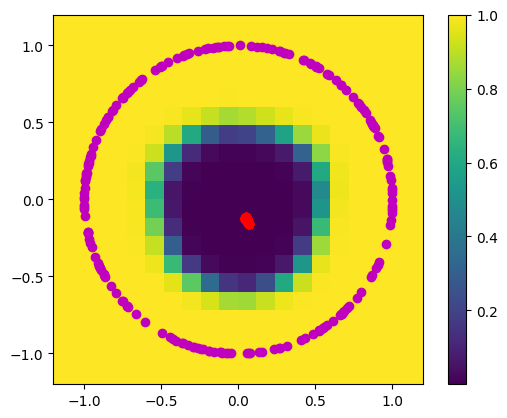

Dloss = 2.2715261e-05 ;Gloss= 11.451159


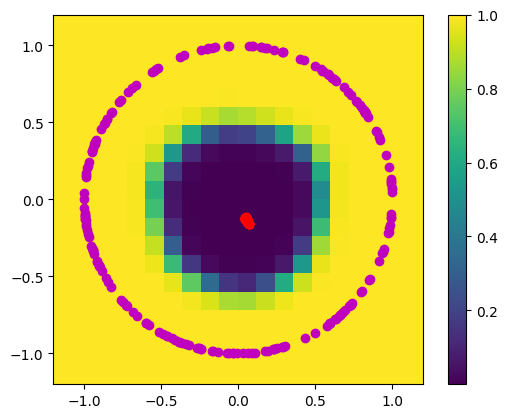

Dloss = 1.8490133e-05 ;Gloss= 11.591994


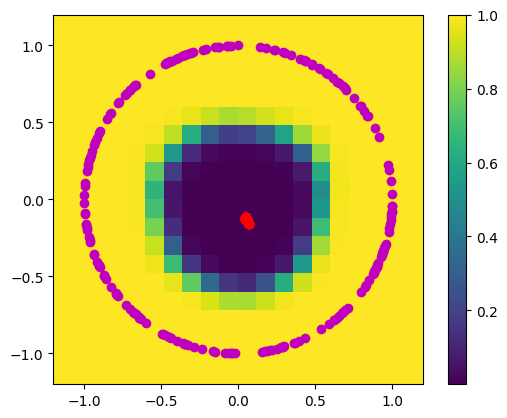

Dloss = 1.5463556e-05 ;Gloss= 11.74088


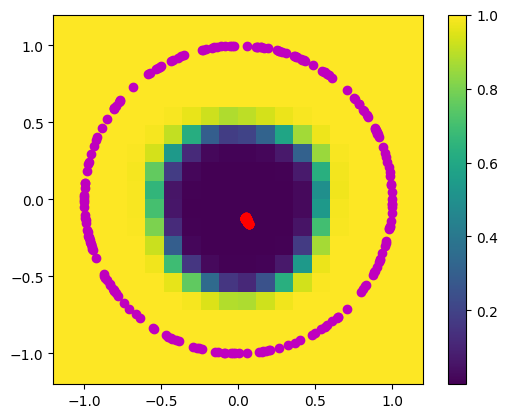

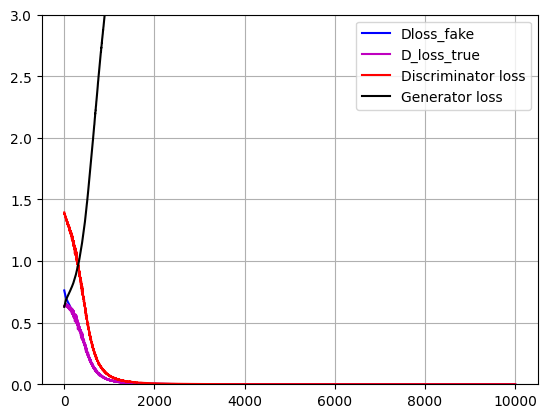

In [4]:
D = discriminator(base_size=30,input_dim=2, output_dim=1,).cuda()
G=generator(base_size=10,output_dim=2).cuda()

batch_sz = 200
z_dim = 1
dataloader=DataLoader(dataset,batch_size=batch_sz,shuffle=True)

G_optimizer = optim.Adam(generator.parameters(G), lr=0.0001)
D_optimizer = optim.Adam(discriminator.parameters(D), lr=0.0001)
BCE_loss = nn.BCELoss().cuda()

index,x_ = next(iter(dataloader))
y_real_, y_fake_ = torch.ones(batch_sz, 1), torch.zeros(batch_sz, 1)
y_real_, y_fake_ = y_real_.cuda(), y_fake_.cuda()

train_hist = {}
train_hist['D_loss_fake'] = []
train_hist['D_loss_true'] = []
train_hist['D_loss_total'] = []
train_hist['G_loss'] = []

for epoch in range(1000):
    for batch_index,x_ in dataloader:

        # Random noise that is fed to the generator
        z_ = 2*torch.rand((batch_sz, 1))-1
        x_, z_ = x_.cuda(), z_.cuda()

        #Discriminator update
        #----------------------
        D_optimizer.zero_grad()
        D_real = D(x_)

        # Discriminator loss on real data
        D_real_loss = BCE_loss(D_real, y_real_)

        G_ = G(z_)
        D_fake = D(G_)
        # Discriminator loss on fake data
        D_fake_loss = BCE_loss(D_fake, y_fake_)

        #Total discriminator loss
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()

        # Generator update
        #----------------------

        G_loss = BCE_loss(D_fake, y_real_)

        train_hist['D_loss_fake'].append(D_fake_loss.item())
        train_hist['D_loss_true'].append(D_real_loss.item())
        train_hist['D_loss_total'].append(D_loss.item())
        train_hist['G_loss'].append(G_loss.item())


    if(np.mod(epoch,25)==0):
        print("Dloss =",D_loss.detach().cpu().numpy(),";Gloss=",G_loss.detach().cpu().numpy())
        plotDiscriminant_And_Points(D,x_,G_,ext=1.2)

plt.figure()
s=plt.plot(train_hist['D_loss_fake'],c='b')
s=plt.plot(train_hist['D_loss_true'],c='m')
s=plt.plot(train_hist['D_loss_total'],c='r')
s=plt.plot(train_hist['G_loss'],c='k')
s = plt.ylim((0,3))
s = plt.grid()
s=plt.legend(('Dloss_fake','D_loss_true','Discriminator loss','Generator loss'))


## Training the generator independently.

The generator adjusts the parameters such that the cross entropy loss between the fake labels and the real labels is decreased.

$$\min_{G}  ~{\rm BCE}\left(D(\underbrace{x_{\rm fake}}_{G[z]}),\underbrace{y_{\rm real}}_1\right)$$

It moves the points to the high values of the discriminant.

Dloss = 1.8451557e-05 ;Gloss= 11.425236


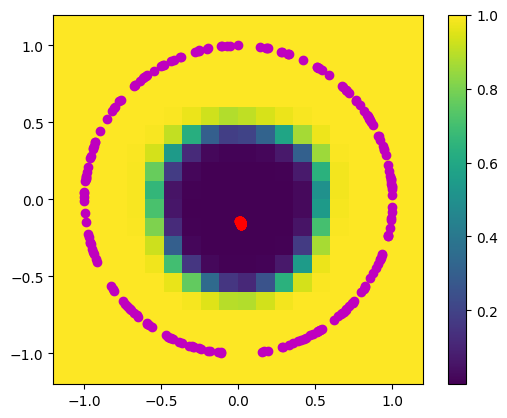

Dloss = 0.021455204 ;Gloss= 3.9136715


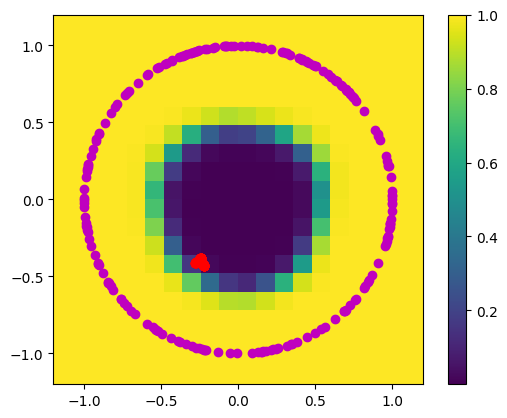

Dloss = 10.187143 ;Gloss= 5.384246e-05


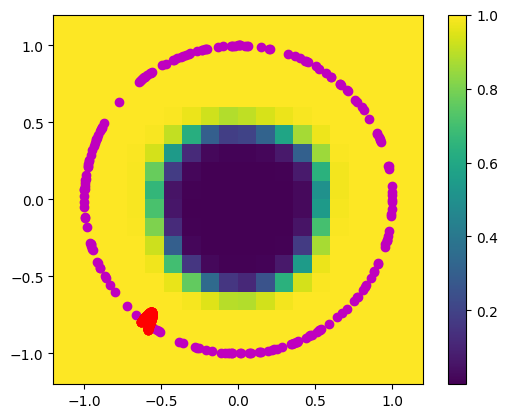

Dloss = 100.00001 ;Gloss= 0.0


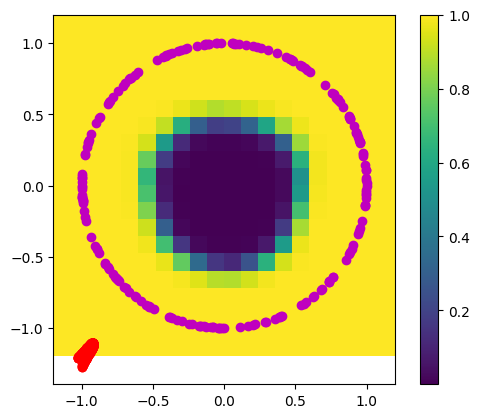

Dloss = 100.00001 ;Gloss= 0.0


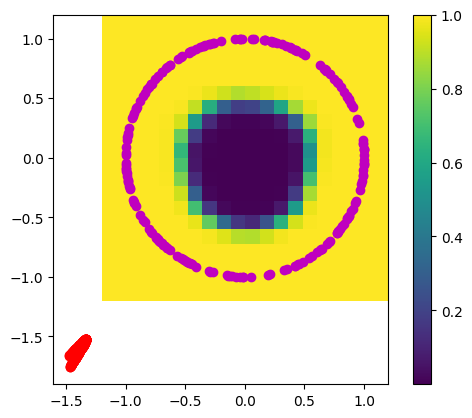

Dloss = 100.00001 ;Gloss= 0.0


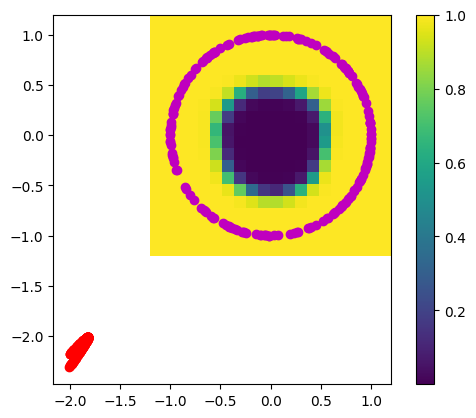

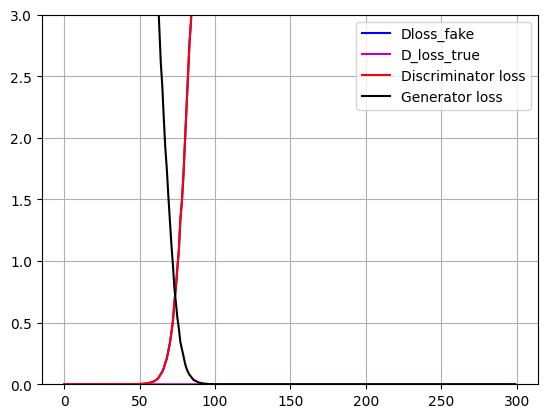

In [5]:
train_hist = {}
train_hist['D_loss_fake'] = []
train_hist['D_loss_true'] = []
train_hist['D_loss_total'] = []
train_hist['G_loss'] = []

for epoch in range(30):
    for batch_index,x_ in dataloader:
        z_ = 2*torch.rand((batch_sz, 1))-1
        x_, z_ = x_.cuda(), z_.cuda()

        G_ = G(z_)
        D_fake = D(G_)
        G_loss = BCE_loss(D_fake, y_real_)

        G_loss.backward()
        G_optimizer.step()

        D_real = D(x_)
        D_real_loss = BCE_loss(D_real, y_real_)

        D_fake_loss = BCE_loss(D_fake, y_fake_)
        D_loss = D_real_loss + D_fake_loss


        train_hist['D_loss_fake'].append(D_fake_loss.item())
        train_hist['D_loss_true'].append(D_real_loss.item())
        train_hist['D_loss_total'].append(D_loss.item())
        train_hist['G_loss'].append(G_loss.item())

    if(np.mod(epoch,5)==0):
        print("Dloss =",D_loss.detach().cpu().numpy(),";Gloss=",G_loss.detach().cpu().numpy())
        plotDiscriminant_And_Points(D,x_,G_)

plt.figure()
s=plt.plot(train_hist['D_loss_fake'],c='b')
s=plt.plot(train_hist['D_loss_true'],c='m')
s=plt.plot(train_hist['D_loss_total'],c='r')
s=plt.plot(train_hist['G_loss'],c='k')
s = plt.ylim((0,3))
s = plt.grid()
s=plt.legend(('Dloss_fake','D_loss_true','Discriminator loss','Generator loss'))


## Joint optimization

Note from above that if the discriminator is not updated, the generator will converge to points that does not make sense. We now perform the min max optimization.

# Losses used for GAN optimization

1. <font color=blue>Discriminator optimization $\min_{D}  \Big({\rm BCE}\left(D(x_{\rm real}),\underbrace{y_{\rm real}}_{1}\right) + {\rm BCE}\left(D(\underbrace{x_{\rm fake}}_{G[z]}),\underbrace{y_{\rm fake}}_0\right)\Big)
$ </font>

The discriminator loss will achieve a low value when it can reliably separate the two classes.

2. <font color=red>Generator optimization $\min_{G}  ~{\rm BCE}\left(D(\underbrace{x_{\rm fake}}_{G[z]}),\underbrace{y_{\rm real}}_1\right)$</font>.

The generator loss will achieve a low value when it can successfully fool the discriminator

Dloss = 1.287238 ;Gloss= 0.7177501


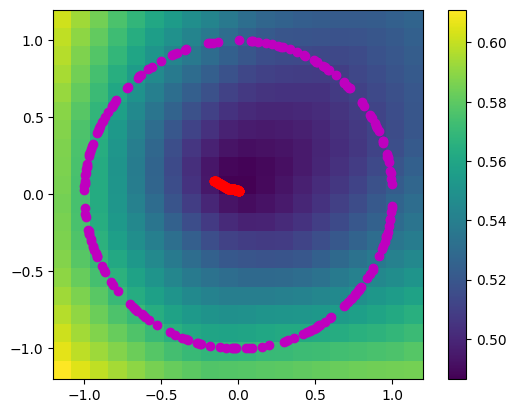

Dloss = 0.5416136 ;Gloss= 1.7699305


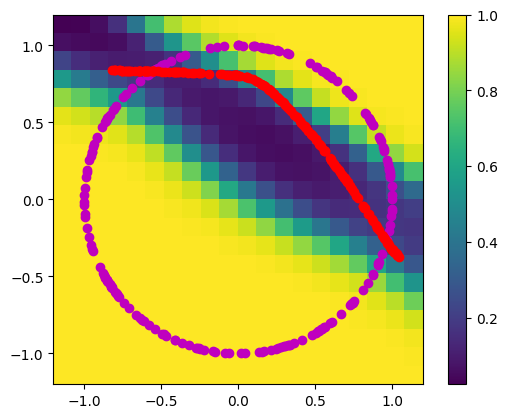

Dloss = 0.88570786 ;Gloss= 1.1956508


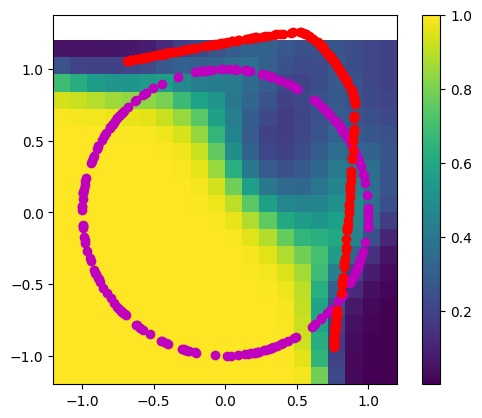

Dloss = 0.96724045 ;Gloss= 1.0670638


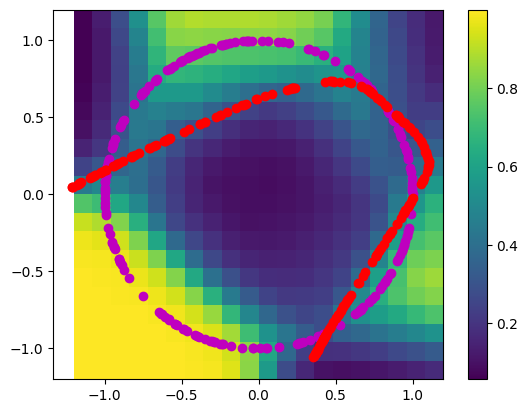

Dloss = 1.043324 ;Gloss= 1.0118563


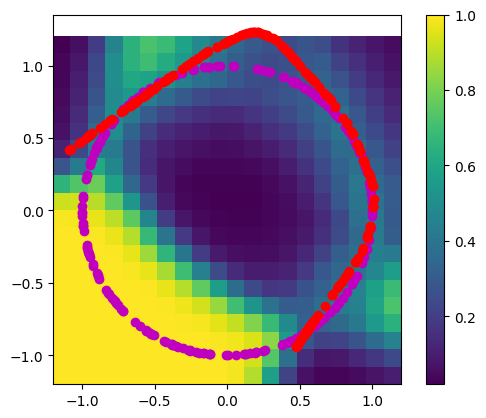

Dloss = 1.1051036 ;Gloss= 0.93748426


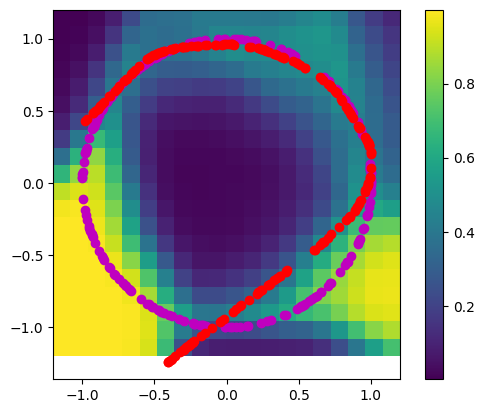

Dloss = 1.1721995 ;Gloss= 0.8594205


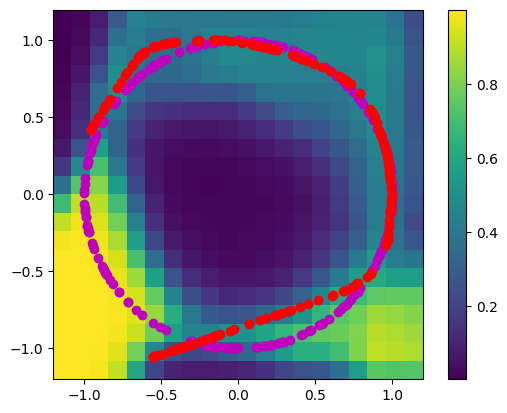

Dloss = 1.264683 ;Gloss= 0.77307355


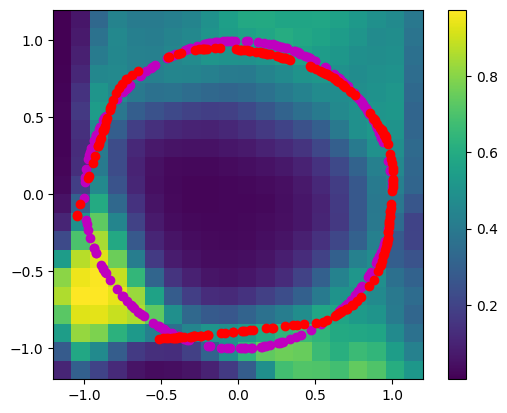

Dloss = 1.3490962 ;Gloss= 0.7142972


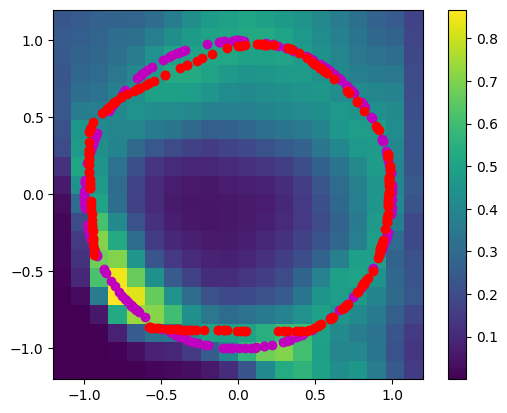

Dloss = 1.387377 ;Gloss= 0.6183424


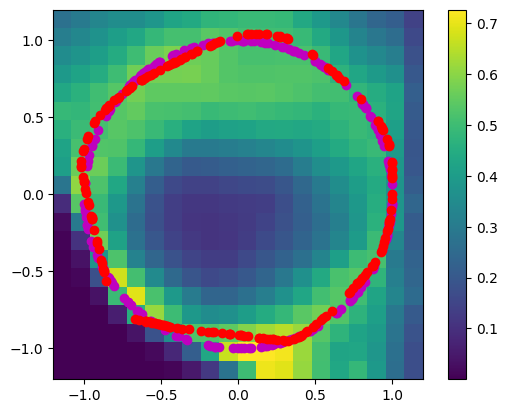

Dloss = 1.3666148 ;Gloss= 0.70758575


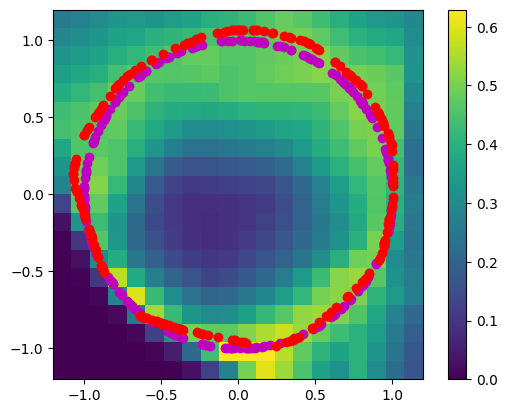

Dloss = 1.3719565 ;Gloss= 0.66343117


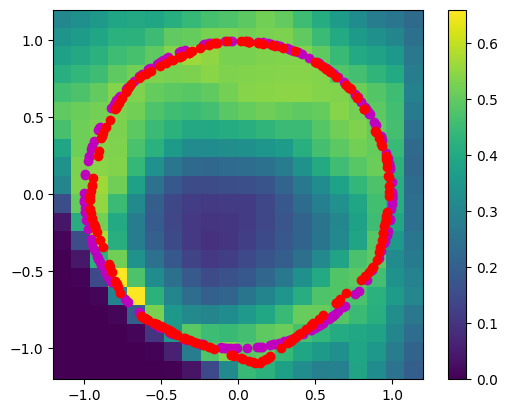

Dloss = 1.3776059 ;Gloss= 0.6818698


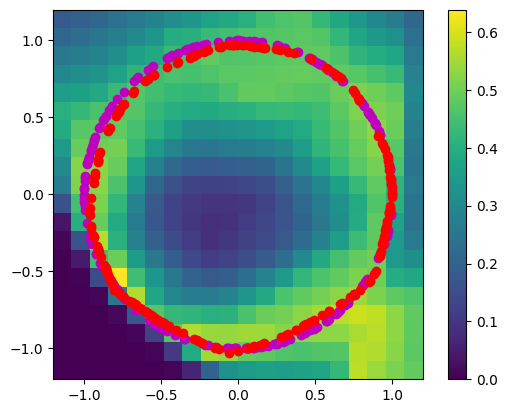

Dloss = 1.3921634 ;Gloss= 0.7238037


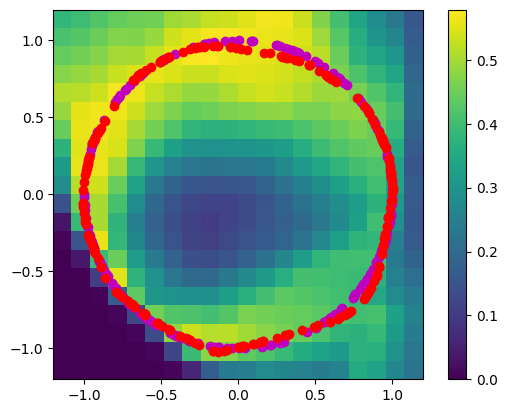

Dloss = 1.3760316 ;Gloss= 0.6765822


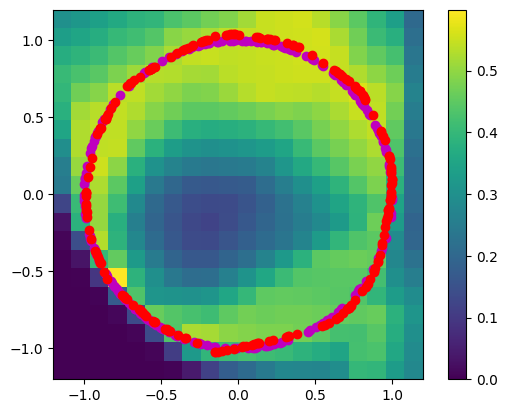

Dloss = 1.3789088 ;Gloss= 0.74307144


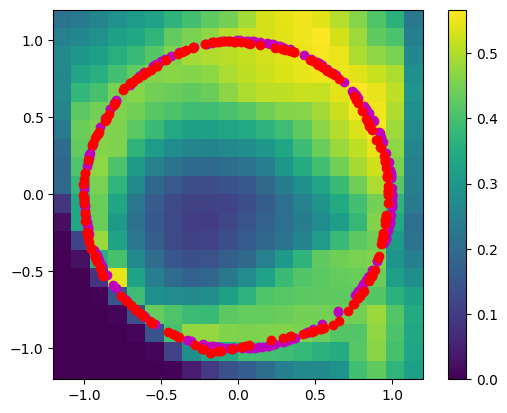

Dloss = 1.3795755 ;Gloss= 0.679942


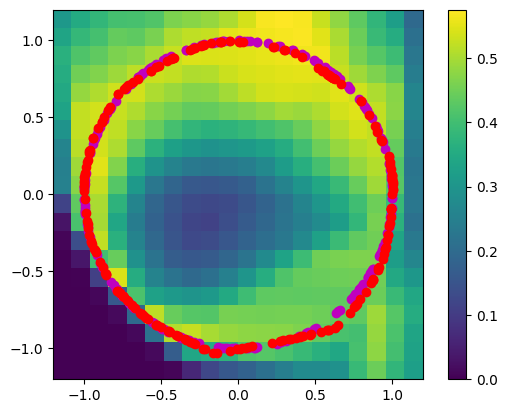

Dloss = 1.3885715 ;Gloss= 0.6382381


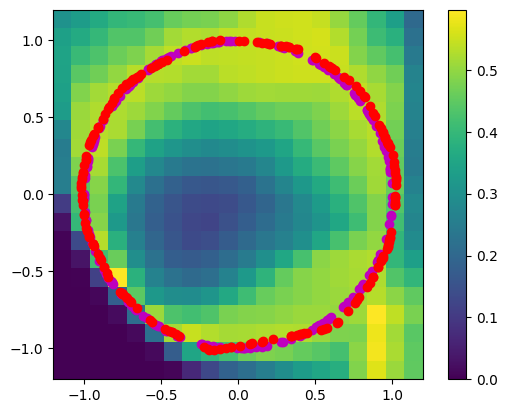

Dloss = 1.3645463 ;Gloss= 0.70171833


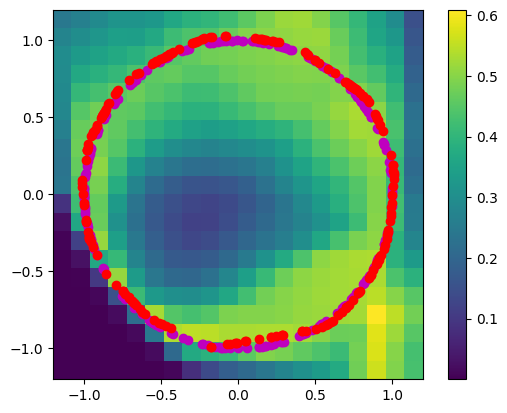

Dloss = 1.3841503 ;Gloss= 0.7118921


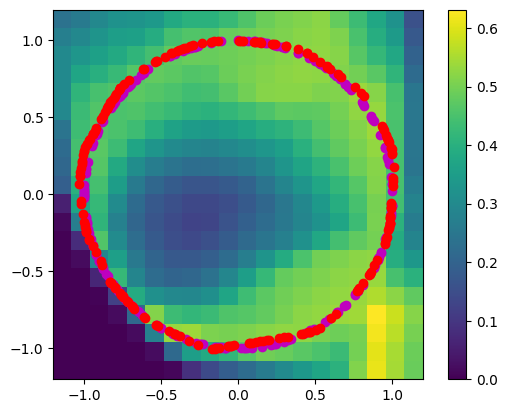

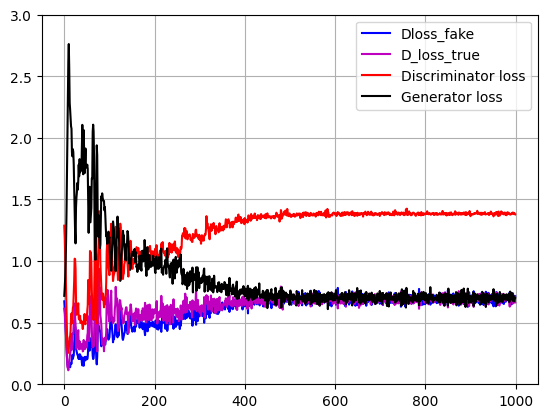

In [7]:

D = discriminator(base_size=30,input_dim=2, output_dim=1,).cuda()
G=generator(base_size=10,output_dim=2).cuda()

batch_sz = 200
z_dim = 1
dataloader=DataLoader(dataset,batch_size=batch_sz,shuffle=True)

G_optimizer = optim.Adam(generator.parameters(G), lr=0.0001)
D_optimizer = optim.Adam(discriminator.parameters(D), lr=0.001)
BCE_loss = nn.BCELoss().cuda()

index,x_ = next(iter(dataloader))
y_real_, y_fake_ = torch.ones(batch_sz, 1), torch.zeros(batch_sz, 1)
y_real_, y_fake_ = y_real_.cuda(), y_fake_.cuda()


Ninner = 1
train_hist = {}
train_hist = {}
train_hist['D_loss_fake'] = []
train_hist['D_loss_true'] = []
train_hist['D_loss_total'] = []
train_hist['G_loss'] = []



for epoch in range(1000):
    for batch_index,x_ in dataloader:
        z_ = 2*torch.rand((batch_sz, 1))-1
        x_, z_ = x_.cuda(), z_.cuda()

        # update D network

        for i in range(Ninner):
          D_optimizer.zero_grad()
          D_real = D(x_)
          D_real_loss = BCE_loss(D_real, y_real_)

          G_ = G(z_)
          D_fake = D(G_)
          D_fake_loss = BCE_loss(D_fake, y_fake_)

          D_loss = D_real_loss + D_fake_loss
          D_loss.backward()
          D_optimizer.step()

        # update G network
        for i in range(Ninner):
          G_optimizer.zero_grad()
          G_ = G(z_)
          D_fake = D(G_)
          G_loss = BCE_loss(D_fake, y_real_)

          G_loss.backward()
          G_optimizer.step()

    train_hist['D_loss_fake'].append(D_fake_loss.item())
    train_hist['D_loss_true'].append(D_real_loss.item())
    train_hist['D_loss_total'].append(D_loss.item())
    train_hist['G_loss'].append(G_loss.item())

    if(np.mod(epoch,50)==0):
        print("Dloss =",D_loss.detach().cpu().numpy(),";Gloss=",G_loss.detach().cpu().numpy())
        z_ = z_.cuda()
        plotDiscriminant_And_Points(D,x_,G_)


plt.figure()
s=plt.plot(train_hist['D_loss_fake'],c='b')
s=plt.plot(train_hist['D_loss_true'],c='m')
s=plt.plot(train_hist['D_loss_total'],c='r')
s=plt.plot(train_hist['G_loss'],c='k')
s = plt.ylim((0,3))
s = plt.grid()
s=plt.legend(('Dloss_fake','D_loss_true','Discriminator loss','Generator loss'))
